In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, stats
from scipy.optimize import minimize
#import scipy.special as sc
import pdb
from deprojectVis import deproject_vis
import time
import d3sbfxns as f #Package together
import emcee
import triangle #called corner on newer distros
from datetime import datetime
#from __future__ import print_function

In [72]:
##Inputs
#Visibility inputs
rhomin = 0.1 #1/arcsec
rhomax = 10. #1/arcsec
Nvis = 100

#Annuli limits in arcsec
rmin = 0.01/140.
rmax = 1.1
global Nrings
Nrings = 40

#GP Hyperparameters
gpa = .15 #Hyperparameter amplitude (.15)
gpl = .1 #Hyperparameter lengthscale (.1)
ggamma = 0.

#Set GP mean in step 3b
synthimg = 'DATA/fullA.image.fits' #File with image to be used for mean

Our data set contains a collection of $N_{vis}$ data visibilities, each indexed by $D_j$. It is represented by a column vector of length $N_{vis}$ as

$$
\vec{D} = \begin{bmatrix}
D_1\\
\vdots\\
D_j\\
\vdots\\
D_{N_{vis}}
\end{bmatrix}.
$$
While $\vec{D}$ has complex elements, we will restrict our attention and modeling to the real part only.

We assume that the data visibilities, $\vec{D}$, are drawn from a multi-dimensional normal distribution, with a covariance matrix ${\Sigma}$.  We assert that the noise on each visibility is Gaussian and independent from every other visibility. This means that $\Sigma$ is a diagonal matrix of size ($N_{vis}$,$N_{vis}$), given by
$$
\Sigma=
  \begin{pmatrix}
  \sigma_1^2 & &0\\
  &\ddots& \\
 0 & & \sigma_{N_{vis}}^2
  \end{pmatrix},
  \qquad
  \Sigma^{-1}=
  \begin{pmatrix}
  \frac{1}{\sigma_1^2} & &0\\
  &\ddots& \\
 0 & & \frac{1}{\sigma_{N_{vis}}^2}
  \end{pmatrix} .
$$

Our model computes a single complex visibility at a particular radial visibility $\rho_j$ as the sum of $N_{ring}$ Bessel functions, each indexed by $i$. This also means that in real space, the model has $N_{rings}$ total bins, each indexed by $i$.

$$
M(\rho_j) = M_j =  \sum_{i=1}^{N_{rings}} {w_i \over \rho_j} \left [{r_b}_i J_1(2\pi {r_b}_i \rho_j) - {r_a}_i J_1(2\pi {r_a}_i \rho_j) \right ] = \sum_i w_i x(\rho_j ; r_{i}),
$$

or in matrix form:
$$
\vec{M} = \undertilde{X}\vec{w},
$$
where $\vec{M}$ is a length-$N_{vis}$ column vector, giving the model visibilities, $X$ is the ($N_{vis}$, $N_{rings}$) design matrix, and $\vec{w}$ is our length-$N_{rings}$ column vector of parameters, which physically are the surface brightness intensity coefficients:

$$
\vec{w}  = \begin{bmatrix}
w_{1} \\
\vdots \\
w_i\\
\vdots \\
w_{N_{rings}}
\end{bmatrix},
\qquad
  \undertilde{X}=
  \begin{pmatrix}
  x (\rho_{1} ;r_{1}) & ... & x(\rho_{1}; r_{i}) & ... & x(\rho_{1} ;r_{N_{rings}})\\
  \vdots & & & & \vdots \\
  x (\rho_{j}; r_{1}) & &\ddots& & x(\rho_{j}; r_{N_{rings}}) \\
  \vdots & & & & \vdots \\
  x(\rho_{N_{vis}} ;r_{1})  & ... & x(\rho_{N_{vis}}; r_{i}) & ... &  x(\rho_{N_{vis}} ;r_{N_{rings}})
  \end{pmatrix}.
$$         

In [73]:
##Make fake visibility data (D) from a fake SB profile with intensity coefficients wtrue

#Set radii for SB annuli and determine wtrue at those locations
radii = np.linspace(rmin, rmax, num=Nrings+1) #arcsec (Currently does NOT use rin)
rleft = radii[:-1]
rright = radii[1:]
rcenter = (rleft+rright)/2.
#Fake SB at those radii
flux = 0.12
sig = 0.6
wtrue = (sig/rcenter)**0.7 * np.exp(-(rcenter/sig)**2.5)# fullA distribution
int_SB = np.trapz(2.*np.pi*wtrue*rcenter, rcenter) # a check on the total flux
wtrue *= flux / int_SB

global D, Sigma, X
#Calculate the fake visibilities (D), corresponding baselines (rho), & weights (Sigmainv)
rho = np.linspace(rhomin, rhomax, Nvis) #Visibility baselines (1/arcsec)
#Calculate the design matrix X
X = np.empty([Nvis,Nrings]) #Design matrix
for j in range(Nvis):
    for i in range(Nrings):
        X[j][i] = 1./rho[j]*(rright[i]*special.j1(rho[j]*2.*np.pi*rright[i]) - rleft[i]*special.j1(rho[j]*2.*np.pi*rleft[i]))
D = np.dot(X, wtrue)
Sigma = np.diag(1.e-6*np.ones(Nvis))
Sigmainv= np.diag(1.e6*np.ones(Nvis)) #Temporarily make up uncertainty.  Uniform values are a good approx. for ALMA data

The likelihood function describing the probability of the data given our model parameters is given by
$$
P\left(\vec{D} \mid \vec{M} \right) = N \left( \vec{D} \mid {X} \vec{w}, {\Sigma}\right),
$$
where
$$
N \left( \vec{D} \mid  {X} \vec{w} , {\Sigma} \right) = \frac{1}{|2 \pi {\Sigma}|} \exp \left[{-\frac{1}{2} (\vec{D}-{X}\vec{w})^T {\Sigma}^{-1} (\vec{D}-{X}\vec{w})} \right].
$$

With a uniform prior on the distribution of intensity coefficients ($P(\vec{w}) = 1$)
$$
P\left(\vec{D}\rvert\vec{w}\right) = P\left(\vec{w}\rvert\vec{D}\right),
$$
the maximum-likelihood solution to this type of problem is given by another multivariate Gaussian with mean
$$
\vec{w_u} = {C_u} \left( {X}^T {\Sigma}^{-1}\vec{D} \right),
$$
with a covariance matrix
$$
{C_u}^{-1} = {X}^T {\Sigma}^{-1}{X}.
$$

In [74]:
##3 - Compute linear algebra

#3a. Calculate MLE mean (wu) and covariance matrix inverse (Cuinv)
Cuinv = np.dot(np.dot(X.T, Sigmainv), X)
Cuinvwu = np.dot(np.dot(X.T, Sigmainv), D) #Cuinv * wu

#Uncomment the following for better numerical stability

#Add epsu to the diagonal of the matrix to make it more numerically stable
#print('Cuinv condition number ', np.linalg.cond(Cuinv))
#epsu = 10**(int(np.log10(np.amin(np.diag(Cuinv))))-2) ##Can Set
#Cuinv = Cuinvorig + epsu*np.eye(Nrings)
#print('Min (Cu diag), Eps', np.amin(np.diag(Cuinv)), epsu)
#print('Cu new condition number ', np.linalg.cond(Cuinv))

We add a Gaussian prior on the intensity coefficients, $P(w)$, since we expect them to vary smoothly.  To do so, we assume a covariance matrix on the intensity coefficients, based on a squared exponential kernel, 
$$
{C_w}_{a,b} = a^2 \exp \left (-\frac{(r_a - r_b)^2}{2 l^2} \right) + \sigma_w^2 \delta_{ab},
$$
where $a$, $l$ and $\sigma_w$ are hyperparameters.  The last term can be included for numerical stability.  

For our prior, we assume that the mean of the intensity coefficients is $\mu$, which we can choose based on the SB image corresponding to our data.  Since this is essentially the truth convolved with a PSF, it looks smeared out - underpredicting intensities at small radii.

In [75]:
##To allow for hyperparameter optimization, we calculate
##the covariance matrix Cw in separate function definitions

#Squared exponential kernel
def exp2kernel(i1, i2, ibins=None, a=None, l=None, gamma=0):
    ri = ibins[i1]
    rj = ibins[i2]
#    tol = 1e-6
#    nugget = np.zeros_like(ri)
#    nugget[(ri-rj)<tol] = 1e-16 #AD HOC!        
    return a*a* ri**gamma * np.exp(-((ri - rj)**2.)/(2.*l*l))#+nugget

In [76]:
#Covariance matrix for intensities
def calccovar(binsin, ain, lin, gammain):
    '''
    Calculate the covariance matrix using a squared exponential kernel
    a: normalization amplitude
    l: correlation length
    '''
    nbins = binsin.shape[0]
    cov = np.fromfunction(exp2kernel,(nbins,nbins), ibins=binsin, a=ain, l=lin, gamma = gammain, dtype = np.int)
    return cov

In [97]:
#3b. Calculate the GP covariance matrix (Cw), with the mean (muw)

#Find image mean
incl = 50. #deg
PA = 70. #deg
offx = -0.3 #arcsec
offy = -0.2 #arcsec
rsb, sb, beaminfo = f.sbdata(synthimg, PA, incl, offx, offy)
sbbin, sigmabin = f.sbmeanbin(rleft[0], rright, rsb, sb)

#Set the mean
global muw
muw = sbbin

#Calculate the covariance matrix
Cworig = calccovar(rcenter, gpa, gpl, ggamma)
print 'Cw condition number ', np.linalg.cond(Cworig)
epsw = np.amin(np.diag(Cworig))
Cw = Cworig + epsw*np.eye(Nrings)
print 'Min(Cw), Min (Cw diag)', np.amin(Cworig), np.amin(np.diag(Cworig))
print 'Eps', epsw
print 'Cw new condition number ', np.linalg.cond(Cw)
Cwinv = np.linalg.inv(Cw)

Cw condition number  1.18099575665e+17
Min(Cw), Min (Cw diag) 2.38742169514e-27 0.0225
Eps 0.0225
Cw new condition number  9.8173330006


With this prior, our data are described as being drawn from a new multiavariate Gaussian distribution with the covariance matrix,
$$
{C_{GP}}^{-1} = {C_{u}}^{-1} + {C_{w}}^{-1},
$$
and mean,
$$
\vec{w}_{GP} = {C_{GP}} \left(  {C_{u}}^{-1} \vec{w}_u +  {C_{w}}^{-1} \vec{\mu} \right).
$$

In [98]:
#3c. Calculate GP prior mean (wgp) and covariance matrix (Cgp)
Cgpinv = Cuinv+Cwinv
Cgp = np.linalg.inv(Cuinv+Cwinv)
wgp = np.linalg.solve(Cgpinv, Cuinvwu + np.dot(Cwinv, muw))

#Print condition number to determine numerical stability
print('Cuinv condition number ', np.linalg.cond(Cuinv))
print('Cgpinv condition number ', np.linalg.cond(Cgpinv))

('Cuinv condition number ', 5.138685111274512e+17)
('Cgpinv condition number ', 22132.066955740909)


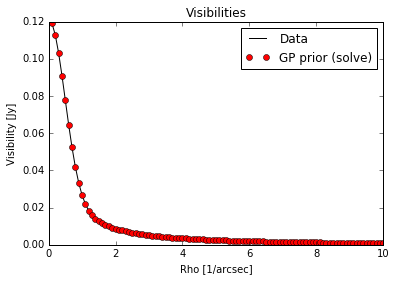

In [99]:
#Plot the results
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, wgp), 'or', label='GP prior (solve)')
plt.ylabel('Visibility [Jy]')
plt.xlabel('Rho [1/arcsec]') 
plt.title('Visibilities')
plt.legend()

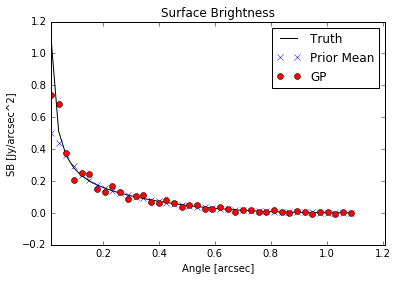

In [100]:
plt.plot(rcenter, wtrue, '-k', label='Truth')
plt.plot(rcenter, muw, 'xb', label='Prior Mean')
plt.plot(rcenter, wgp, 'or', label='GP')
plt.ylabel('SB [Jy/arcsec^2]')
plt.xlabel('Angle [arcsec]') 
plt.title('Surface Brightness')
#ax = plt.gca()
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.xlim(.9*rcenter[0], 1.1*rmax)
plt.legend()

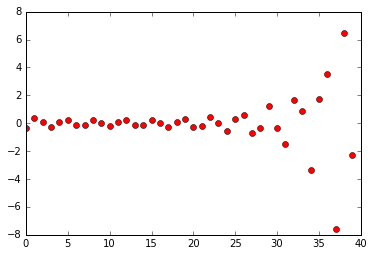

In [101]:
plt.plot((wgp-wtrue)/wtrue,'or')

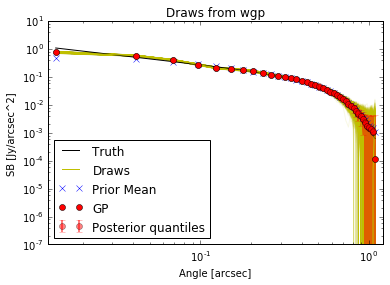

In [96]:
gpdraws = np.random.multivariate_normal(wgp, Cgp, size=1000) #Choice of Cgpinv inversion matters 
post = np.percentile(gpdraws, [16, 50, 84], axis=0)
loerr = post[1]-post[0]
hierr = post[2]-post[1]

plt.title('Draws from wgp')
plt.ylabel('SB [Jy/arcsec^2]')
plt.xlabel('Angle [arcsec]')
plt.plot(rcenter, wtrue, '-k', label='Truth')
plt.plot(rcenter, gpdraws[0], '-y', label='Draws')
for draw in gpdraws:
        plt.plot(rcenter, draw, '-y', alpha = 0.1, zorder=1)
        
plt.plot(rcenter, muw, 'xb', label='Prior Mean')
plt.plot(rcenter, wgp, 'or', label='GP')        
plt.errorbar(rcenter, post[1], yerr = [loerr, hierr], fmt='or', elinewidth=2, alpha = 0.5, label='Posterior quantiles')
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(.9*rcenter[0], 1.1*rmax)
plt.legend(loc='best')

To choose appropriate hyperparameters, we can optimize the evidence:
$$\log{\mathcal{Z}(a, l)} = -{1\over2} \log \det \left(2 \pi {K}(a,l) \right) -{1\over2} \left(\vec{D}-{X}\vec{\mu}\right)^T{K}(a,l)^{-1}\left(\vec{D}-{X}\vec{\mu}\right),
$$
where
$$
{K}(a,l) = {\Sigma} + {X} {C_w}(a,l){X}^T.
$$

In [ ]:
#Calculate the evidence as a function of GP amplitude and length
def calcZ(theta, cb):    
    #Nrings, D, sigma, muw and X are global vars.
    
    if (Nrings - cb.size) > 1e-6: print('Size mismatch \n')
    ggpa = 10.**theta[0]
    ggpl = theta[1]
    ggamma = 0.

    if (ggpa < 0) or (ggpa > 10):
        return -np.inf

    if (ggpl < 0) or (ggpl > (cb[-1]-cb[0])):
        return -np.inf
    
    Corig = calccovar(cb, ggpa, ggpl, ggamma)
    C = Corig #+ np.amin(Corig)*np.eye(Nrings) #Add nugget term for stability, changes based on params.
    K = Sigma + np.dot(np.dot(X,C),np.transpose(X))
    (sign,logdet) = np.linalg.slogdet(2.*np.pi*K)
    logZ = -.5*(logdet+np.dot(np.dot(np.transpose(D-np.dot(X, muw)),np.linalg.inv(K)),(D-np.dot(X, muw))))
    if (sign<0): 
        print("Warning, negative determinant with (A,l,gamma)", ggpa, ggpl, ggamma)
        return -np.inf
    return logZ

Let's use emcee to explore $\log(a)$ and $l$.

In [ ]:
#Initialize walkers
def initgpa(params, nwalkers):
    #This is specific to GP amplitude, not generic parameters
    tmp = np.zeros((nwalkers,2))
    tmp[:,0] = np.random.uniform(-2,0,nwalkers)
    tmp[:,1] = params[1]*(1+np.random.uniform(-0.5,0.5,nwalkers))
    return tmp

In [ ]:
def runemcee(pin, cb, nsteps, nthreads, savename, meanw):
    """
    Run emcee
    :param pin: Parameters
    :param nsteps: Number of MCMC steps to take
    :param savename: Output file name prefix
    :param meanw: Mean to use for covariance
    """
    #Number of parameters and walkers, set by p0
    ndim = 2#np.shape(pin)[1]
    nwalkers = 100#ndim * 4
    
    #Initialize GP param walkers
    p0 = initgpa(pin, nwalkers)
    
    #Setup sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calcZ, threads=nthreads, args=[cb])

    #Run emcee, and time it
    tic = time.time()
    sampler.run_mcmc(p0, nsteps)
    toc = time.time()

    #Display and record run information
    print('Elapsed emcee run time:', ((toc-tic)/60.))
    print('Acceptance:', sampler.acceptance_fraction)

    #Save the results in a binary file
    np.save('mc_'+savename,sampler.chain)

    print('Done with this emcee run')

    return sampler.chain

In [ ]:
#Run emcee
nsteps = 2000
nthreads = 2 #Increase to match the number of cores

notes = raw_input('Notes? Only give a short phrase to append to filenames\n')
savename = notes+'_'+str(Nrings)
chain1 = runemcee([gpa, gpl], rcenter, nsteps, nthreads, savename, muw)


In [ ]:
#Look at posteriors for hyperparameters
samples = chain1.reshape((-1,2))
fig = triangle.corner(samples, labels=['log(a)', 'l'],quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [ ]:
post = np.percentile(samples, [16, 50, 84], axis=0)
#These hyperparameter values can be reinput at the top of the notebook and steps 3b, 3c, and plotting rerun.

In [33]:
#Let's try SVD
U, s, V = np.linalg.svd(Cuinv, full_matrices=True)
Ugp, sgp, Vgp = np.linalg.svd(Cgpinv, full_matrices=True)


In [13]:
S = np.diag(s)

In [14]:
s.shape
s

array([  8.95529301e+05,   2.38343715e+05,   1.39554398e+05,
         9.71443149e+04,   7.45544862e+04,   5.99752415e+04,
         5.00182072e+04,   4.25946995e+04,   3.69279919e+04,
         3.23664077e+04,   2.86405218e+04,   2.54682116e+04,
         2.27176157e+04,   2.02211541e+04,   1.78863877e+04,
         1.55978971e+04,   1.33302122e+04,   1.10469452e+04,
         8.79890595e+03,   6.66068194e+03,   5.11719694e+03,
         3.57293371e+03,   1.34684195e+03,   2.67961344e+02,
         5.38653209e+00,   6.44634507e-02,   5.10004437e-04,
         2.75916949e-06,   1.03632568e-08,   2.03818329e-10,
         7.90314224e-11,   7.23209770e-11,   7.23209770e-11,
         7.23209770e-11,   7.23209770e-11,   7.23209770e-11,
         7.23209770e-11,   7.23209770e-11,   7.23209770e-11,
         7.23209770e-11])

In [29]:
s2 = 1./s
print s2
s2[s2>1e7]=0.
print s2

[  1.11665805e-06   4.19562143e-06   7.16566452e-06   1.02939632e-05
   1.34130091e-05   1.66735469e-05   1.99927198e-05   2.34770995e-05
   2.70797286e-05   3.08962307e-05   3.49155650e-05   3.92646337e-05
   4.40187040e-05   4.94531615e-05   5.59084383e-05   6.41112062e-05
   7.50175607e-05   9.05227628e-05   1.13650493e-04   1.50134777e-04
   1.95419487e-04   2.79882047e-04   7.42477617e-04   3.73188157e-03
   1.85648202e-01   1.55126663e+01   1.96076726e+03   3.62427899e+05
   9.64947622e+07   4.90633010e+09   1.26531950e+10   1.38272468e+10
   1.38272468e+10   1.38272468e+10   1.38272468e+10   1.38272468e+10
   1.38272468e+10   1.38272468e+10   1.38272468e+10   1.38272468e+10]
[  1.11665805e-06   4.19562143e-06   7.16566452e-06   1.02939632e-05
   1.34130091e-05   1.66735469e-05   1.99927198e-05   2.34770995e-05
   2.70797286e-05   3.08962307e-05   3.49155650e-05   3.92646337e-05
   4.40187040e-05   4.94531615e-05   5.59084383e-05   6.41112062e-05
   7.50175607e-05   9.05227628e-0

In [36]:
Sbar = np.linalg.inv(S)
Sbargp = np.linalg.inv(np.diag(sgp))
xhat = np.dot(np.dot(np.dot(V, Sbar),U.T),Cuinvwu)
print xhat
xhatgp = np.dot(np.dot(np.dot(Vgp, Sbargp),Ugp.T), Cuinvwu + np.dot(Cwinv, muw))
print xhatgp
print sgp

[ 0.609375   -0.03125    -0.640625    0.18554688 -0.203125    0.0859375
  0.09375     0.3515625   0.546875   -0.203125   -0.1171875   0.51171875
  0.04882812  0.00585938  0.3671875   0.1484375   0.1640625   0.1796875
  0.0234375  -0.171875   -0.25       -0.203125    0.2265625   0.25
 -0.296875   -0.53125     0.21875    -0.140625    0.265625    0.05859375
  0.1015625   0.1328125   0.0859375   0.4375      0.19335938 -0.3046875
 -0.14282227 -0.35546875 -0.421875   -0.15625   ]
[-0.16295575  0.05194275  0.26879538  0.17312778  0.12833361  0.02352377
 -0.06217811 -0.04940085  0.03545843  0.12659097 -0.2696746   0.30901326
  0.19343628 -0.10471976  0.1204968  -0.24411252  0.17892125 -0.08328569
 -0.1259115  -0.24924942 -0.30346638 -0.15152369  0.20132932 -0.08719211
  0.06855474 -0.19492227 -0.23116871 -0.11821419  0.13030864  0.15696851
  0.24205332  0.13736538 -0.16138204 -0.63794773  0.09913042  0.00233145
  0.01353622  0.00756213  0.00376549  0.00094384]
[  9.41836188e+17   5.87406247e+1

In [30]:
Sbar2 = np.diag(s2)
xhat2 = np.dot(np.dot(np.dot(V, Sbar2),U.T),Cuinvwu)
xhat2

array([ 0.15494275,  0.11694977, -0.11791301, -0.14353547, -0.0849241 ,
        0.26971483, -0.16498315, -0.09181938,  0.23630548, -0.17322353,
       -0.07141483,  0.33636915,  0.31599396,  0.1819188 ,  0.31735232,
        0.15304729,  0.14235011,  0.19103467,  0.03009629, -0.13333791,
       -0.26326969, -0.14873405,  0.22343655,  0.0098049 , -0.11703687,
       -0.19287121, -0.16038835, -0.0242033 ,  0.10803133,  0.08402126,
       -0.06625947, -0.04001319,  0.17122754,  0.17539468,  0.29466277,
       -0.05924487, -0.16078848, -0.26442114, -0.24332541, -0.40545052])

In [22]:
wu = np.linalg.solve(Cuinv, Cuinvwu)
wu

array([  6.97150135e+00,  -4.34042328e+00,   3.58322571e+00,
        -1.27926292e+00,   3.97989191e-01,   1.12313087e+00,
        -1.52692330e+00,   2.19089908e+00,  -1.64598835e+00,
         1.19355741e+00,  -2.08223231e-01,   8.34602285e-02,
        -5.63648380e-02,   5.59457020e-01,  -4.60311585e-01,
         2.33412092e-01,   4.18450729e-01,  -6.06828691e-01,
         6.08084635e-01,  -2.14488393e-01,   9.33889871e-02,
        -1.10048329e-01,   4.18917844e-01,  -5.50283172e-01,
         5.49681035e-01,  -3.01854753e-01,   1.23885381e-01,
        -3.70369999e-02,   1.50708943e-01,  -2.85465220e-01,
         3.99259870e-01,  -3.86557221e-01,   3.12703578e-01,
        -1.94847986e-01,   1.06402537e-01,  -4.23615565e-02,
         1.63856180e-02,  -2.65309266e-03,   1.49130167e-03,
         5.74972391e-04])

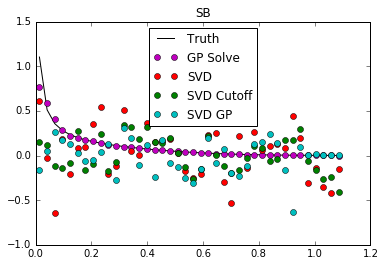

In [49]:
plt.title('SB')
plt.plot(rcenter, wtrue, 'k', label='Truth')
#plt.plot(rcenter, wu, 'ob', label='Solve')
plt.plot(rcenter, wgp, 'om', label='GP Solve')
plt.plot(rcenter, xhat, 'or', label='SVD')
plt.plot(rcenter, xhat2, 'og', label='SVD Cutoff')
plt.plot(rcenter, xhatgp, 'oc', label='SVD GP')
plt.legend(loc='best')

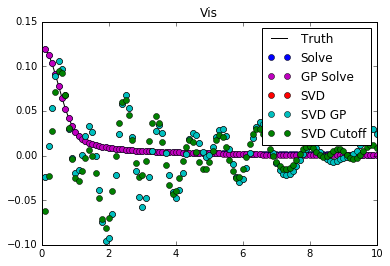

In [48]:
plt.title('Vis')
plt.plot(rho, np.dot(X,wtrue), 'k', label='Truth')
plt.plot(rho, np.dot(X,wu), 'ob', label='Solve')
#plt.plot(rho, np.dot(X,wgp), 'om', label='GP Solve')
plt.plot(rho, np.dot(X,xhat), 'or', label='SVD')
plt.plot(rho, np.dot(X,xhat), 'oc', label='SVD GP')
plt.plot(rho, np.dot(X,xhat2), 'og', label='SVD Cutoff')
plt.legend(loc='best')

In [61]:
print np.sum(Cw, axis=0)

[ 0.11380054  0.13546575  0.15480787  0.17081841  0.18310605  0.19184968
  0.19761835  0.2011471   0.20314846  0.20420089  0.20471401  0.20494597
  0.20504319  0.20508097  0.20509458  0.20509913  0.20510054  0.20510094
  0.20510105  0.20510108  0.20510108  0.20510105  0.20510094  0.20510054
  0.20509913  0.20509458  0.20508097  0.20504319  0.20494597  0.20471401
  0.20420089  0.20314846  0.2011471   0.19761835  0.19184968  0.18310605
  0.17081841  0.15480787  0.13546575  0.11380054]


In [63]:
np.linalg.cond(Cw)

1.1809957566513413e+17

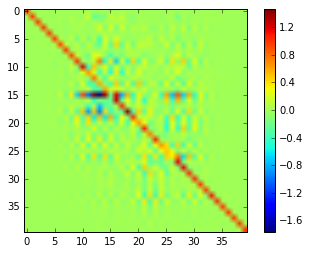

In [79]:
plt.imshow(np.dot(Cw, Cwinv))
plt.colorbar()